<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
import seaborn as sns
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# NLP libraries
import nltk
import re
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
oversample = RandomOverSampler(sampling_strategy='minority')

In [13]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url)

In [14]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['x', 'y']

In [1]:
df = pd.read_excel(r"C:\Users\HP\Desktop\vs codes\NLP\(sample Data) - Copy.xlsx")

NameError: ignored

In [ ]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['x', 'y']

In [ ]:
df.y.value_counts()

SERVICE                      335
APPLICATION (WEB/APP)        262
NOT SPECIFIED                126
CHARGES(BRO./DP/LPC ETC.)     55
PEOPLE                        16
PROCESS                        3
Name: y, dtype: int64

In [ ]:
df = df[df['x'].apply(lambda x: not isinstance(x, int))]

In [ ]:
df['category_id'] = df['y'].factorize()[0]
from io import StringIO
category_id_df = df[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=20, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(df['x']).toarray()
labels = df.category_id
features.shape

(796, 41)

In [ ]:
# We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for i, j in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == j)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(i))
    # print(feature_names)
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'APPLICATION (WEB/APP)':
 Most correlated unigrams:
. order
. app
 Most correlated bigrams:
. kotak securities
. customer service
# 'CHARGES(BRO./DP/LPC ETC.)':
 Most correlated unigrams:
. charges
. brokerage
 Most correlated bigrams:
. customer service
. kotak securities
# 'NOT SPECIFIED':
 Most correlated unigrams:
. app
. good
 Most correlated bigrams:
. kotak securities
. customer service
# 'PEOPLE':
 Most correlated unigrams:
. customer
. support
 Most correlated bigrams:
. kotak securities
. customer service
# 'PROCESS':
 Most correlated unigrams:
. account
. times
 Most correlated bigrams:
. customer service
. kotak securities
# 'SERVICE':
 Most correlated unigrams:
. app
. service
 Most correlated bigrams:
. kotak securities
. customer service


In [ ]:
X_train = features
Y_train = labels

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


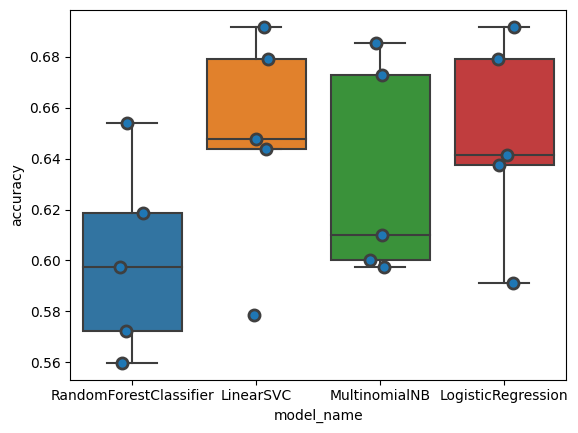

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, Y_train, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
model = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, stratify=labels, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
y_pred_overall = model.predict(features)

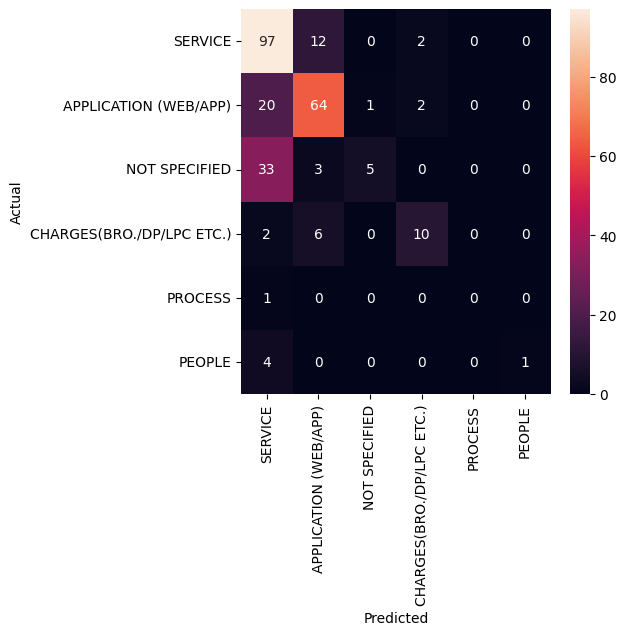

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

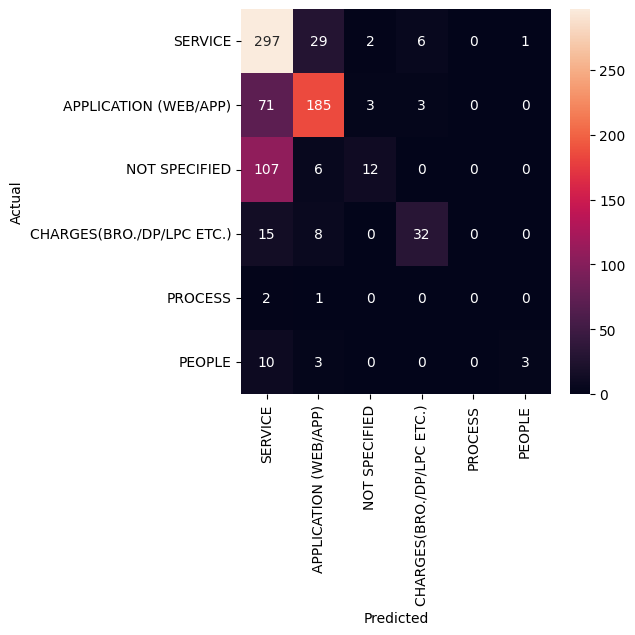

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels, y_pred_overall)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['y', 'x']])
            print('')

'APPLICATION (WEB/APP)' predicted as 'SERVICE' : 71 examples.


,y,x
482,APPLICATION (WEB/APP),"Suggestions made before, I didnt see improveme..."
773,APPLICATION (WEB/APP),Reatime data delayed to reflect on dashboard
172,APPLICATION (WEB/APP),Improve tecanical chart and easy to use
415,APPLICATION (WEB/APP),Kindly improve overall experience
34,APPLICATION (WEB/APP),Why my account suspendFive days please solve m...
28,APPLICATION (WEB/APP),How to set target price is not given. Executed...
665,APPLICATION (WEB/APP),My positions were diluted due to your pathetic...
774,APPLICATION (WEB/APP),Improve speed.due to hanging problem we lost m...
745,APPLICATION (WEB/APP),For diposit funds take more than 2hrs try many...
171,APPLICATION (WEB/APP),Direct Debit from Kotak Savings A/C to Trading...



'NOT SPECIFIED' predicted as 'SERVICE' : 107 examples.


,y,x
381,NOT SPECIFIED,"sorry, you do not have time to attend , subscr..."
325,NOT SPECIFIED,Improvement is must needed
669,NOT SPECIFIED,Please have a check and balance for review
562,NOT SPECIFIED,No
60,NOT SPECIFIED,Not called
759,NOT SPECIFIED,Wants to close relationship
522,NOT SPECIFIED,Ok
584,NOT SPECIFIED,Nothing to write. I am sure you know it but re...
712,NOT SPECIFIED,Not satisfied
74,NOT SPECIFIED,Thank You



'CHARGES(BRO./DP/LPC ETC.)' predicted as 'SERVICE' : 15 examples.


,y,x
692,CHARGES(BRO./DP/LPC ETC.),Loot by you of account holder. Very high charg...
728,CHARGES(BRO./DP/LPC ETC.),Employees are unavailable to contact for quarr...



'PEOPLE' predicted as 'SERVICE' : 10 examples.


,y,x
731,PEOPLE,No communication from your end reg customer su...
715,PEOPLE,High level of confusion while squatting off po...
322,PEOPLE,Call not castmecar supportPlese andher call na...
131,PEOPLE,Please improve your support



'SERVICE' predicted as 'APPLICATION (WEB/APP)' : 29 examples.


,y,x
139,SERVICE,Bad experience in all the interactions â€¦ als...
17,SERVICE,"Pathetic if ur management is listening, follow..."
771,SERVICE,The employees are not contacting for any issue...
764,SERVICE,Should have trading RM in nearest Bank. So the...
320,SERVICE,Worst service and I lost 60000 rupees in two d...
228,SERVICE,Your app is not trustworthy Customer care numb...
83,SERVICE,"kotak neo is bad application ,lot of technical..."
790,SERVICE,Third class service..my all over 50000 loss fo...
699,SERVICE,No call back reply on trading buying and selli...
200,SERVICE,I am recommending 0 because advisors are too s...



'NOT SPECIFIED' predicted as 'APPLICATION (WEB/APP)' : 6 examples.


,y,x
527,NOT SPECIFIED,Bad experience
384,NOT SPECIFIED,I received a info about HDFC life Insurance sh...
625,NOT SPECIFIED,do not trade with Kotak sec at all



'CHARGES(BRO./DP/LPC ETC.)' predicted as 'APPLICATION (WEB/APP)' : 8 examples.


,y,x
705,CHARGES(BRO./DP/LPC ETC.),"I used to be an active customer of yours, but ..."
643,CHARGES(BRO./DP/LPC ETC.),App experience is very very poor. In web you ...
400,CHARGES(BRO./DP/LPC ETC.),Pl resolve my issue immediately without delay ...
667,CHARGES(BRO./DP/LPC ETC.),As and when there are changes in Interest or a...
600,CHARGES(BRO./DP/LPC ETC.),1)Kotak online app to mesimplfied.2)I sell sha...
377,CHARGES(BRO./DP/LPC ETC.),Brkrage plan is high thats why now started in...



'SERVICE' predicted as 'CHARGES(BRO./DP/LPC ETC.)' : 6 examples.


,y,x
0,SERVICE,Querries where Kotak is at disadvantageous pos...
231,SERVICE,Ask the expert in Chat is seldom helpful.custo...


In [ ]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(labels, y_pred_overall, target_names=df['y'].unique()))

                           precision    recall  f1-score   support

                  SERVICE       0.59      0.89      0.71       335
    APPLICATION (WEB/APP)       0.80      0.71      0.75       262
            NOT SPECIFIED       0.71      0.10      0.17       125
CHARGES(BRO./DP/LPC ETC.)       0.78      0.58      0.67        55
                  PROCESS       0.00      0.00      0.00         3
                   PEOPLE       0.75      0.19      0.30        16

                 accuracy                           0.66       796
                macro avg       0.60      0.41      0.43       796
             weighted avg       0.69      0.66      0.62       796



c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m